In [1]:
import pandas as pd
from darts.models import TFTModel
import numpy as np
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt

In [2]:
file_path = 'processed_datasetNew.csv'
data = pd.read_csv(file_path)

data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

In [3]:
split_date = pd.to_datetime('2008-12-31 23:59')
data = data[data.index >= split_date]

In [4]:
data["Temperature t+24"] = data["Temperature"].shift(periods=-24)
data["Humidity t+24"] = data["Humidity"].shift(periods=-24)
data["Month"] = data.index.month
data["Month_sin"] = np.sin(2 * np.pi * data.index.month / 12)
data["Month_cos"] = np.cos(2 * np.pi * data.index.month / 12)
data["Month t+24"] = data["Month"].shift(periods=-24)
data["Month_sin t+24"] = data["Month_sin"].shift(periods=-24)
data["Month_cos t+24"] = data["Month_cos"].shift(periods=-24)
data["Quarter"] = data.index.quarter
data["Quarter_sin"] = np.sin(2 * np.pi * data.index.quarter / 4)
data["Quarter_cos"] = np.cos(2 * np.pi * data.index.quarter / 4)
data["Quarter t+24"] = data["Quarter"].shift(periods=-24)
data["Quarter_sin t+24"] = data["Quarter_sin"].shift(periods=-24)
data["Quarter_cos t+24"] = data["Quarter_cos"].shift(periods=-24)
data["Year"] = data.index.year
data["Year t+24"] = data["Year"].shift(periods=-24)
data['week_cos'] =  np.cos(2 * np.pi * data.index.isocalendar().week / 53)
data['week_sin'] =  np.sin(2 * np.pi * data.index.isocalendar().week / 53)
data["week_sin t+24"] = data["week_sin"].shift(periods=-24)
data["week_cos t+24"] = data["week_cos"].shift(periods=-24)
data['weekday_cos'] = np.sin(2 * np.pi * (data.index.weekday+1) / 7)
data['weekday_sin'] = np.cos(2 * np.pi * (data.index.weekday+1) / 7)
data["weekday_sin t+24"] = data["weekday_sin"].shift(periods=-24)
data["weekday_cos t+24"] = data["weekday_cos"].shift(periods=-24)

In [5]:
features_options = [
    ["Temperature", "Humidity"],
    ["Temperature", "Humidity", "Year", "Month"],
    ["Temperature", "Humidity", "Year", "Month", "Month_cos", "Month_sin"],
    ["Temperature", "Humidity", "Year", "Month", "Month_cos", "Month_sin", "weekday_cos", "weekday_sin"],
    ["Temperature", "Humidity", "Temperature t+24", "Humidity t+24"],
    ["Temperature", "Humidity", "Year", "Month", "Temperature t+24", "Humidity t+24", "Year t+24", "Month t+24"],
    ["Temperature", "Humidity", "Year", "Month", "Month_cos", "Month_sin", "Temperature t+24", "Humidity t+24", "Year t+24", 
    "Month t+24", "Month_cos t+24", "Month_sin t+24"],
    ["Temperature", "Humidity", "Year", "Month", "Month_cos", "Month_sin", "weekday_cos", "weekday_cos", "Temperature t+24", "Humidity t+24",
    "Year t+24", "Month t+24", "Month_cos t+24", "Month_sin t+24", "weekday_cos t+24", "weekday_sin t+24"],
    ["Temperature", "Humidity", "Year", "weekday_cos", "weekday_sin", "Month_cos", "Month_sin"],
    ["Temperature", "Humidity", "Year", "weekday_cos", "weekday_sin", "Temperature t+24", "Humidity t+24", "Year t+24", "weekday_cos t+24", "weekday_sin t+24"]
]

In [6]:
data_sin = data[['SIN']]
data_cov = data[features_options[8]]

In [7]:
series = TimeSeries.from_dataframe(data_sin, value_cols=["SIN"])
covariates = TimeSeries.from_dataframe(data_cov, value_cols=features_options[8])
series = series.astype(np.float32)
covariates = covariates.astype(np.float32)

In [8]:
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)

In [9]:
# Add holiday binary value
covariates_holiday = covariates.add_holidays('PY')

In [10]:
# # Create training and validation sets:
training_cutoff = pd.Timestamp("20191231T230000")
train, val = series.split_after(training_cutoff)
# validation_cutoff = pd.Timestamp("20211231T230000")
# val, test = val.split_after(validation_cutoff)

In [11]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [12]:
covariates = covariates.astype(np.float32)
covariates_holiday = covariates_holiday.astype(np.float32)
cov_train, cov_val = covariates.split_after(training_cutoff)
cov_train_holiday, cov_val_holiday = covariates_holiday.split_after(training_cutoff)
# cov_val, cov_test = covariates.split_after(validation_cutoff)

In [13]:
scaler_covs = Scaler()
covariates_transformed_train = scaler_covs.fit_transform(cov_train)
covariates_transformed_val = scaler_covs.transform(cov_val)
covariates_transformed = scaler_covs.transform(covariates)

scaler_covs_holiday = Scaler()
covariates_transformed_train_holiday = scaler_covs_holiday.fit_transform(cov_train_holiday)
covariates_transformed_val_holiday = scaler_covs_holiday.transform(cov_val_holiday)
covariates_transformed_holiday = scaler_covs_holiday.transform(covariates_holiday)

In [14]:
covariates_holiday

<TimeSeries (DataArray) (Date: 122712, component: 9, sample: 1)>
array([[[ 2.6749483e+01],
        [ 6.9609451e+01],
        [ 2.0090000e+03],
        ...,
        [ 5.0000000e-01],
        [ 0.0000000e+00],
        [ 1.0000000e+00]],

       [[ 2.6485027e+01],
        [ 7.2481354e+01],
        [ 2.0090000e+03],
        ...,
        [ 5.0000000e-01],
        [ 1.0000000e+00],
        [ 1.0000000e+00]],

       [[ 2.6220570e+01],
        [ 7.5353264e+01],
        [ 2.0090000e+03],
        ...,
...
        ...,
        [-2.4492937e-16],
        [ 1.2270900e+05],
        [ 0.0000000e+00]],

       [[ 3.5726601e+01],
        [ 2.5315716e+01],
        [ 2.0220000e+03],
        ...,
        [-2.4492937e-16],
        [ 1.2271000e+05],
        [ 0.0000000e+00]],

       [[ 3.3234097e+01],
        [ 2.9163977e+01],
        [ 2.0220000e+03],
        ...,
        [-2.4492937e-16],
        [ 1.2271100e+05],
        [ 0.0000000e+00]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2009-01-01 ... 2022-12-31T23:00:00
  * component  (component) object 'Temperature' 'Humidity' ... 'holidays'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Date'>

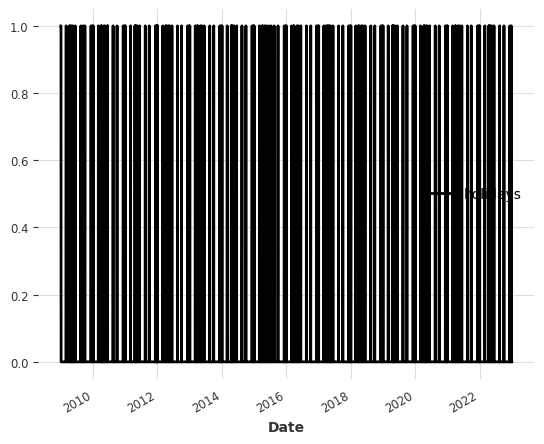

In [15]:
covariates_holiday['holidays'].plot()

In [16]:
df = covariates_holiday['holidays'].pd_dataframe()

In [17]:
df = df[df.index < '01-01-2015']

<Axes: xlabel='Date'>

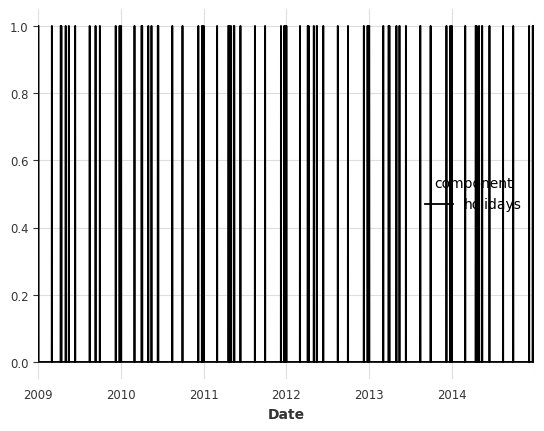

In [18]:
df.plot()

In [19]:
# Resample to daily data and use `max` to mark the entire day as a holiday if any hour is a holiday
daily_holidays = df['holidays'].resample('D').max()

# Convert the resampled data back to a DataFrame
daily_holidays_df = daily_holidays.to_frame().reset_index()

# Display the first few rows of the daily holidays DataFrame
daily_holidays_df.head()

,Date,holidays
0,2009-01-01,1.0
1,2009-01-02,0.0
2,2009-01-03,0.0
3,2009-01-04,0.0
4,2009-01-05,0.0


In [20]:
daily_holidays_df

,Date,holidays
0,2009-01-01,1.0
1,2009-01-02,0.0
2,2009-01-03,0.0
3,2009-01-04,0.0
4,2009-01-05,0.0
...,...,...
2186,2014-12-27,0.0
2187,2014-12-28,0.0
2188,2014-12-29,0.0
2189,2014-12-30,0.0


In [21]:
daily_holidays_df = daily_holidays_df.set_index('Date')
daily_holidays_df.index = pd.to_datetime(daily_holidays_df.index)

In [22]:
daily_holidays_df

,holidays
Date,
2009-01-01,1.0
2009-01-02,0.0
2009-01-03,0.0
2009-01-04,0.0
2009-01-05,0.0
...,...
2014-12-27,0.0
2014-12-28,0.0
2014-12-29,0.0


In [28]:
daily_holidays_df.to_csv('daily_holidays.csv', index=True)

In [38]:
plt.rcParams['axes.titlesize'] = 22  # Title size
plt.rcParams['axes.labelsize'] = 20  # Axis label size
plt.rcParams['xtick.labelsize'] = 18 # X-axis tick label size
plt.rcParams['ytick.labelsize'] = 18 # Y-axis tick label size
plt.rcParams['legend.fontsize'] = 22 # Legend font size

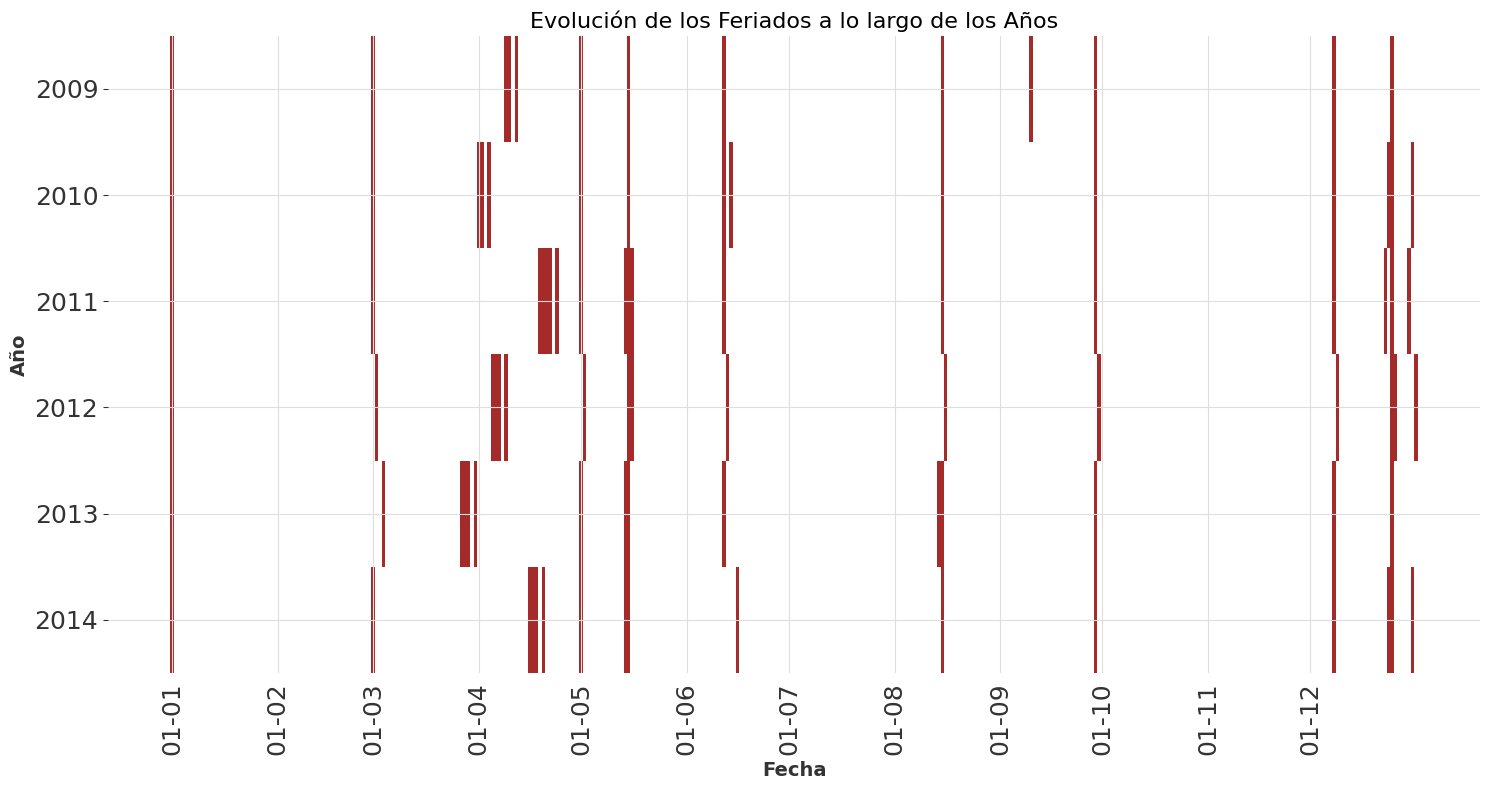

In [43]:
# It seems we need to plot the holidays as filled areas where each holiday spans a vertical space throughout the year.
# We will use a bar plot where each bar's width is very thin, essentially creating a line for each holiday.

# Generate a list of first days of each month for the year
first_days_month = pd.date_range(start=f'{start_year}-01-01', end=f'{start_year}-12-31', freq='MS')
# Create the labels for the first day of each month (01-Jan, 01-Feb, ...)
month_labels = first_days_month.strftime('%d-%m')
# Get the positions for these labels (day of the year for each first day of the month)
month_positions = first_days_month.dayofyear

start_year = daily_holidays_df.index.year.min()
end_year = daily_holidays_df.index.year.max()

# Set up the plot with the appropriate figure size
fig, ax = plt.subplots(figsize=(15, 8))

# Filter the DataFrame for rows where 'holidays' is 1 and create a bar for each day that is a holiday
for year in range(start_year, end_year + 1):
    # Extract the days of the year that are holidays for this particular year
    days_of_year = daily_holidays_df[
        (daily_holidays_df.index.year == year) & (daily_holidays_df['holidays'] == 1)
    ].index.dayofyear
    # Plot each day as a thin vertical bar
    ax.bar(days_of_year, height=1, width=1.0, bottom=year - 0.5, color='brown', align='center')

# Set the labels and title with Spanish text
ax.set_xlabel('Día del año', fontsize=14)
ax.set_ylabel('Año', fontsize=14)
ax.set_title('Evolución de los Feriados a lo largo de los Años', fontsize=16)

ax.set_xticks(month_positions)
ax.set_xticklabels(month_labels, rotation=90)

# Set the labels and title with Spanish text
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Año', fontsize=14)
ax.set_title('Evolución de los Feriados a lo largo de los Años', fontsize=16)

# # Set the x-axis to show days of the year from 1 to 365/366
# ax.set_xlim(1, 366)

# Set the y-axis to show the range of years
ax.set_ylim(start_year - 0.5, end_year + 0.5)
ax.set_yticks(range(start_year, end_year + 1))
ax.set_yticklabels(range(start_year, end_year + 1))

# Invert y-axis so the latest year is at the top
ax.invert_yaxis()

# Adding grid lines for clarity
ax.grid(True)



# Adjust the layout and show the plot
plt.tight_layout()

plt.savefig('holiday_distribution.png', format='png', dpi=300)

plt.show()


In [ ]:
df['SIN'] = series['SIN'].pd_dataframe()

In [ ]:
import seaborn as sns

# plt.rcParams['axes.titlesize'] = 22  # Title size
# plt.rcParams['axes.labelsize'] = 20  # Axis label size
# plt.rcParams['xtick.labelsize'] = 18 # X-axis tick label size
# plt.rcParams['ytick.labelsize'] = 18 # Y-axis tick label size
# plt.rcParams['legend.fontsize'] = 18 # Legend font size

# Box plot to show the distribution of SIN values on holidays vs. non-holidays
plt.figure(figsize=(10, 6))
sns.boxplot(x='holidays', y='SIN', data=df)
plt.title('Box Plot del SIN en Feriados vs. No Feriados')
plt.xlabel('Feriados (0 = No Feriado, 1 = Feriado)')
plt.ylabel('SIN (MW)')

plt.tight_layout()
plt.savefig('box_plot_holidays.png', format='png', dpi=300)

plt.show()

# Violin plot to show the density and distribution of SIN values on holidays vs. non-holidays
plt.figure(figsize=(10, 6))
sns.violinplot(x='holidays', y='SIN', data=df)
plt.title('Violin Plot del SIN en Feriados vs. No Feriados')
plt.xlabel('Feriados (0 = No Feriado, 1 = Feriadoy)')
plt.ylabel('SIN (MW)')

plt.tight_layout()
plt.savefig('violin_plot_holidays.png', format='png', dpi=300)

plt.show()

In [ ]:
from darts.models import TFTModel, ARIMA, RNNModel
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError

tft_model_path = "Models/TFT_2009-2022_09/tft_model_09.pt"
tft_holiday = TFTModel.load(tft_model_path)

tft_model_path = "Models/TFT_2009-2022_07/tft_model_07.pt"
tft_no_holiday = TFTModel.load(tft_model_path)

In [ ]:
n = len(val)  # Get the length of the validation dataset
tft_pred_val_holiday = tft_holiday.predict(n=n, future_covariates=covariates_transformed_holiday)
tft_pred_val_holiday = transformer.inverse_transform(tft_pred_val_holiday)

tft_pred_val_no_holiday = tft_no_holiday.predict(n=n, future_covariates=covariates_transformed)
tft_pred_val_no_holiday = transformer.inverse_transform(tft_pred_val_no_holiday)

In [ ]:
tft_pred_val_arr_holiday = tft_pred_val_holiday.values()
tft_pred_val_arr_no_holiday = tft_pred_val_no_holiday.values()

val_arr = val.values()

In [ ]:
val[26304-(24*7):26304]

In [ ]:
plt.rcParams['axes.titlesize'] = 22  # Title size
plt.rcParams['axes.labelsize'] = 20  # Axis label size
plt.rcParams['xtick.labelsize'] = 18 # X-axis tick label size
plt.rcParams['ytick.labelsize'] = 18 # Y-axis tick label size
plt.rcParams['legend.fontsize'] = 18 # Legend font size

In [ ]:
# Extracting the first week from actual and prediction data
valid_1w = val[17544:17544+(24*7)]
tft_pred_1w_no_holiday = tft_pred_val_holiday[17544:17544+(24*7)]
tft_pred_1w_holiday = tft_pred_val_no_holiday[17544:17544+(24*7)]
# tft_pred_1w_05 = tft_pred_val_05[:24*7]

# Plotting model predictions for the first 24 hours
plt.figure(figsize=(20, 8))
valid_1w.plot(label='Verdadero', lw=2)
tft_pred_1w_no_holiday.plot(label='TFT Sin Feriados', lw=2)
tft_pred_1w_holiday.plot(label='TFT Con Feriados', lw=2)
plt.xlabel('Fecha')
plt.title("Predicciones vs. Valores Actuales 1ra Semana Enero")
plt.legend()

plt.tight_layout()
plt.savefig('holidays_comp_1w_jan.png', format='png', dpi=300)

plt.show()

In [ ]:
# Extracting the first week from actual and prediction data
valid_1w = val[26304-(24*7):26304]
tft_pred_1w_no_holiday = tft_pred_val_holiday[26304-(24*7):26304]
tft_pred_1w_holiday = tft_pred_val_no_holiday[26304-(24*7):26304]
# tft_pred_1w_05 = tft_pred_val_05[:24*7]

# Plotting model predictions for the first 24 hours
plt.figure(figsize=(20, 8))
valid_1w.plot(label='Verdadero', lw=2)
tft_pred_1w_no_holiday.plot(label='TFT Sin Feriados', lw=2)
tft_pred_1w_holiday.plot(label='TFT Con Feriados', lw=2)
plt.xlabel('Fecha')
plt.title("Predicciones vs. Valores Actuales Última Semana Diciembre")
plt.legend()

plt.tight_layout()
plt.savefig('holidays_comp_4w_jan.png', format='png', dpi=300)

plt.show()